In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


In [7]:
train_features = pd.read_csv("dengue_features_train.csv")
train_labels = pd.read_csv("dengue_labels_train.csv")
test_features = pd.read_csv("dengue_features_test.csv")


In [8]:
train = train_features.merge(train_labels, on=['city', 'year', 'weekofyear'])


In [9]:
print(train.shape)
print(train.head())
print(train.info())
print(train.describe())


(1456, 25)
  city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0   sj  1990          18      1990-04-30  0.122600  0.103725  0.198483   
1   sj  1990          19      1990-05-07  0.169900  0.142175  0.162357   
2   sj  1990          20      1990-05-14  0.032250  0.172967  0.157200   
3   sj  1990          21      1990-05-21  0.128633  0.245067  0.227557   
4   sj  1990          22      1990-05-28  0.196200  0.262200  0.251200   

    ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  ...  \
0  0.177617                 12.42             297.572857  ...   
1  0.155486                 22.82             298.211429  ...   
2  0.170843                 34.54             298.781429  ...   
3  0.235886                 15.36             298.987143  ...   
4  0.247340                  7.52             299.518571  ...   

   reanalysis_relative_humidity_percent  reanalysis_sat_precip_amt_mm  \
0                             73.365714                         12.42   
1      

<Figure size 1200x400 with 0 Axes>

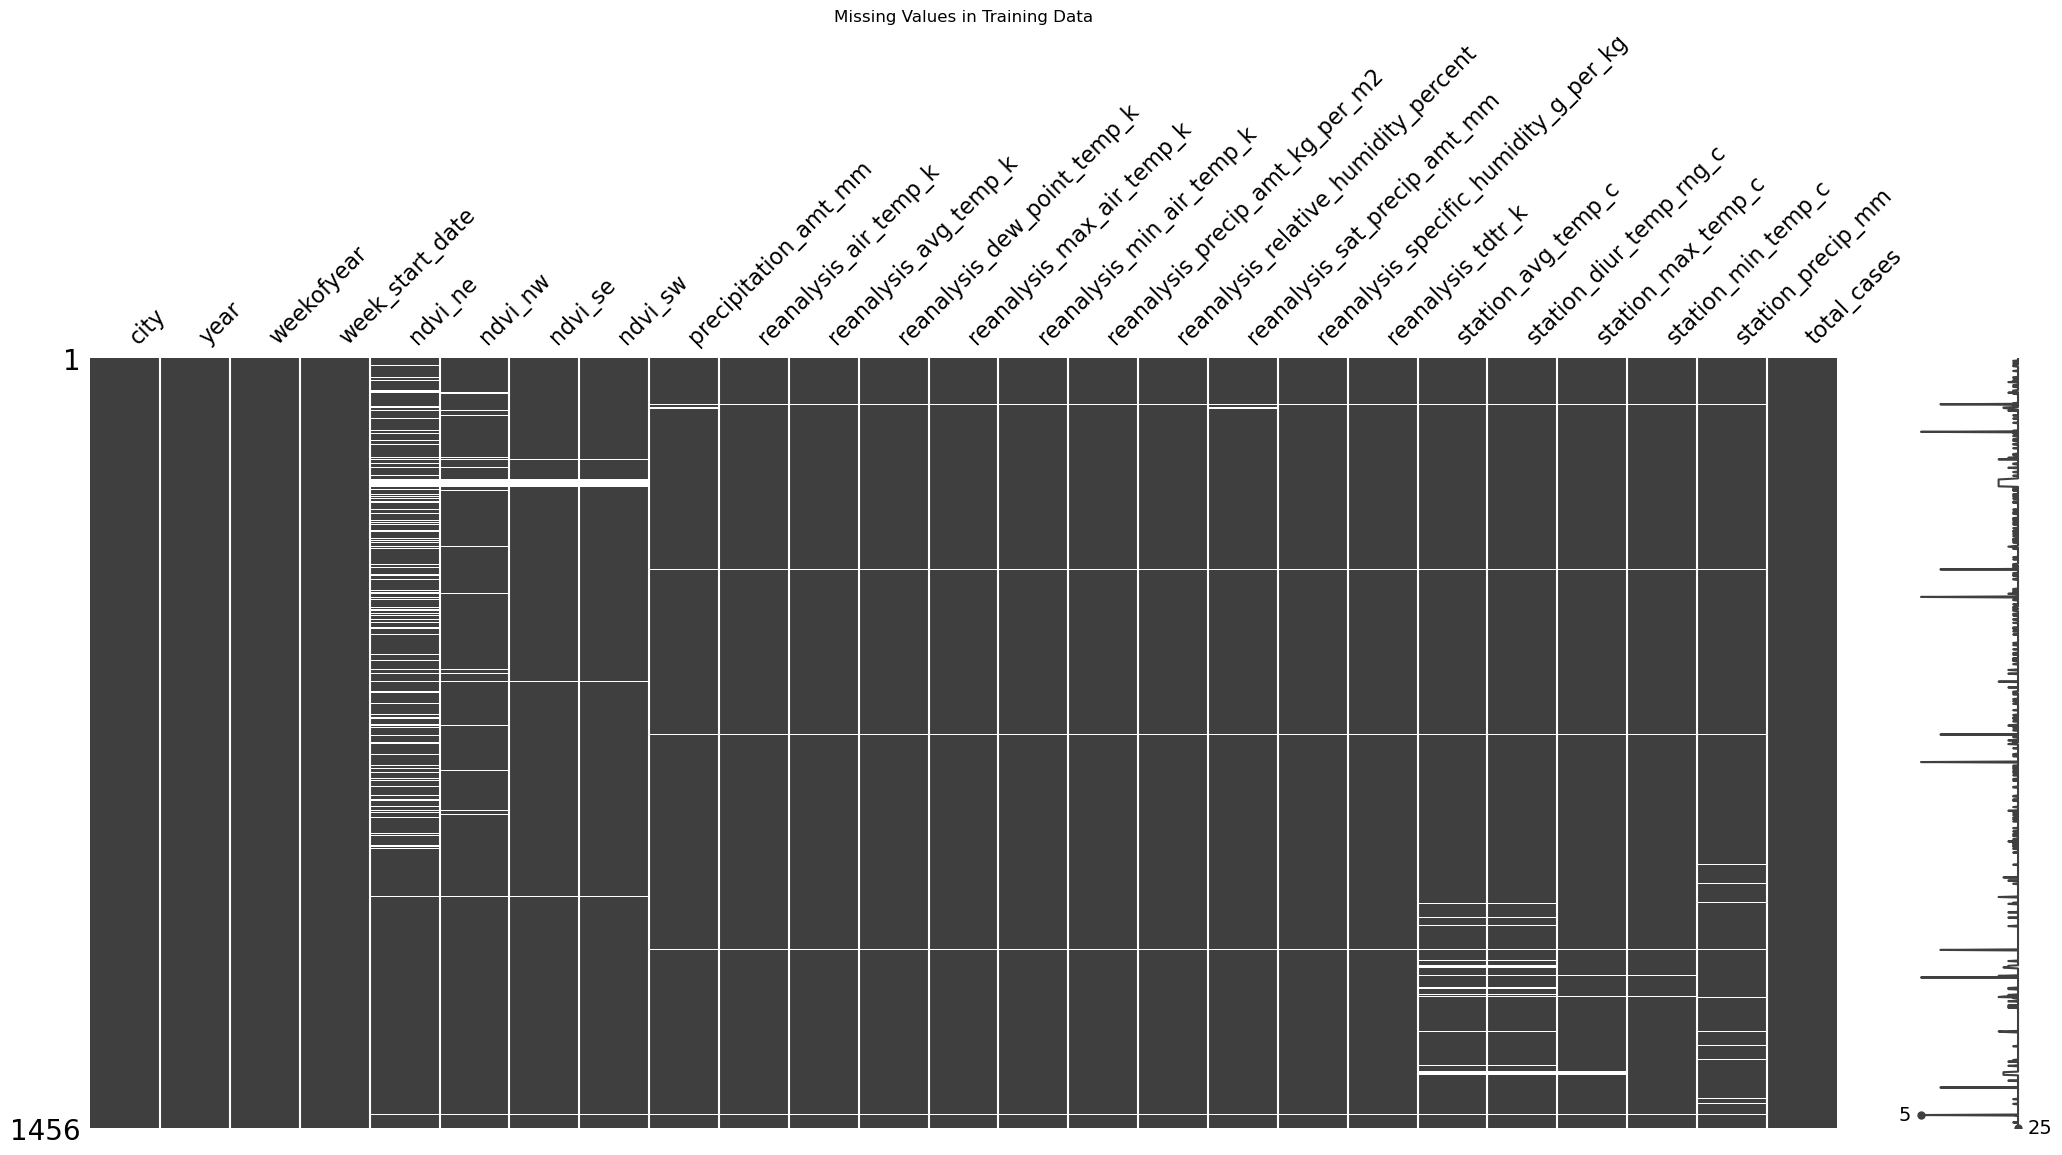

In [10]:
# 🧼 Missing Values Heatmap
# -------------------------
plt.figure(figsize=(12, 4))
msno.matrix(train)
plt.title("Missing Values in Training Data")
plt.show()

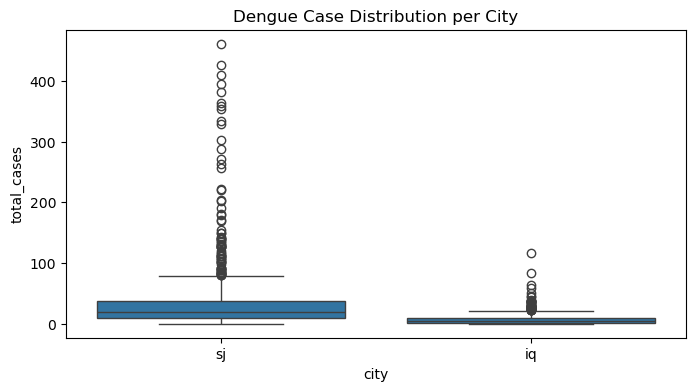

In [11]:
# 📦 Dengue Cases per City
# -------------------------
plt.figure(figsize=(8, 4))
sns.boxplot(data=train, x="city", y="total_cases")
plt.title("Dengue Case Distribution per City")
plt.show()


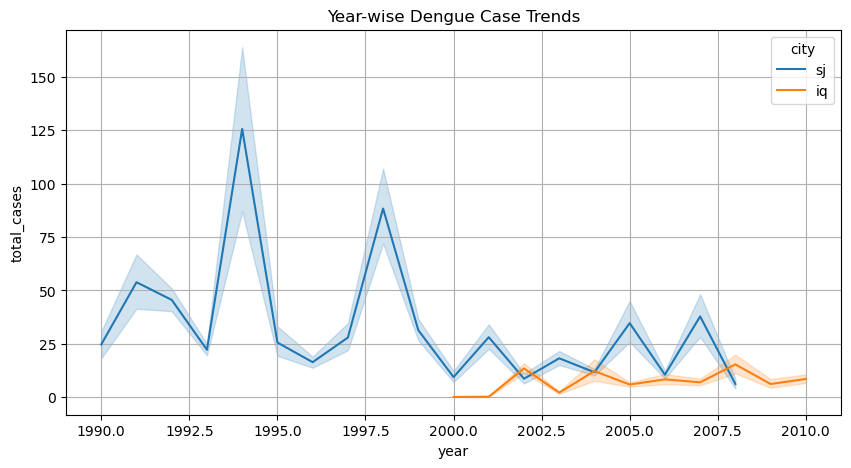

In [12]:
# 📈 Dengue Cases per Year
# -------------------------
plt.figure(figsize=(10, 5))
sns.lineplot(data=train, x="year", y="total_cases", hue="city")
plt.title("Year-wise Dengue Case Trends")
plt.grid()
plt.show()


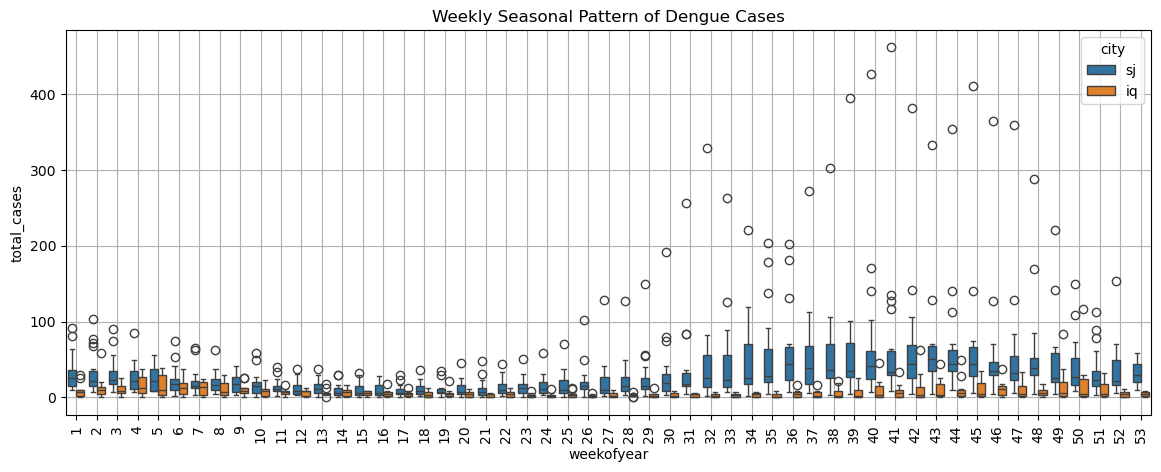

In [13]:
# 📅 Weekly Seasonal Trend
# -------------------------
plt.figure(figsize=(14, 5))
sns.boxplot(data=train, x="weekofyear", y="total_cases", hue="city")
plt.title("Weekly Seasonal Pattern of Dengue Cases")
plt.xticks(rotation=90)
plt.grid()
plt.show()

C:\Users\mharo\AppData\Local\Temp\ipykernel_1732\684245299.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = train.fillna(method='ffill')
C:\Users\mharo\AppData\Local\Temp\ipykernel_1732\684245299.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette="viridis")


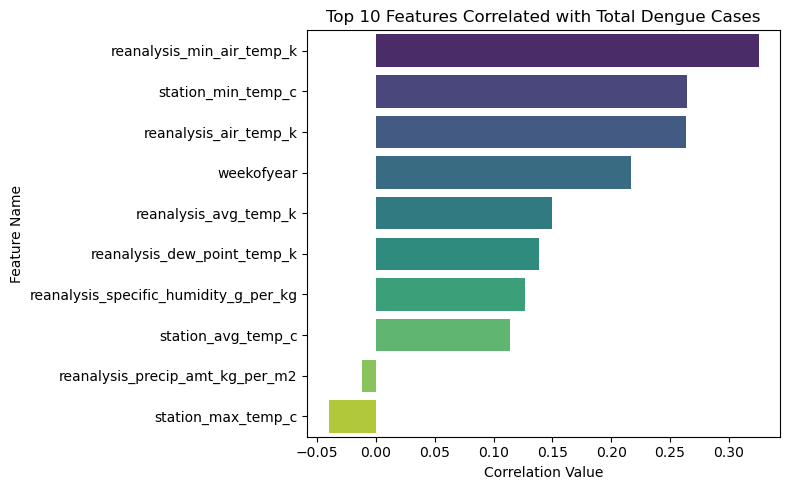

In [16]:
train = train_features.merge(train_labels, on=["city", "year", "weekofyear"])

# Step 2: Encode 'city' column (sj = 0, iq = 1)
train['city'] = train['city'].map({'sj': 0, 'iq': 1})

# Step 3: Drop non-numeric column 'week_start_date'
train = train.drop(columns=['week_start_date'])

# Step 4: Fill missing values using forward fill (or choose mean/median)
train = train.fillna(method='ffill')

# Step 5: Select only numeric columns for correlation
numeric_train = train.select_dtypes(include=[np.number])

# Step 6: Compute correlation matrix
corr_matrix = numeric_train.corr()

# Step 7: Sort correlations with 'total_cases' (excluding self)
top_corr = corr_matrix['total_cases'].sort_values(ascending=False)[1:11]

# Step 8: Plot top correlated features
plt.figure(figsize=(8, 5))
sns.barplot(x=top_corr.values, y=top_corr.index, palette="viridis")
plt.title("Top 10 Features Correlated with Total Dengue Cases")
plt.xlabel("Correlation Value")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()


In [17]:


# 👉 1. Temperature ranges
train["reanalysis_temp_range_k"] = train["reanalysis_max_air_temp_k"] - train["reanalysis_min_air_temp_k"]
train["station_temp_range_c"] = train["station_max_temp_c"] - train["station_min_temp_c"]

# 👉 2. Mean temperatures (already exist, but just in case)
train["reanalysis_mean_temp_k"] = (train["reanalysis_max_air_temp_k"] + train["reanalysis_min_air_temp_k"]) / 2
train["station_mean_temp_c"] = (train["station_max_temp_c"] + train["station_min_temp_c"]) / 2

# 👉 3. Rolling mean of humidity (3-week window)
train["humidity_roll_mean_3"] = train["reanalysis_relative_humidity_percent"].rolling(window=3).mean()

# 👉 4. Lag feature: total cases from previous week
train["lag_1_total_cases"] = train["total_cases"].shift(1)

# 👉 5. Drop initial rows with NaNs from rolling/lag
train = train.dropna().reset_index(drop=True)

# Final check
print(train[["reanalysis_temp_range_k", "station_temp_range_c", "humidity_roll_mean_3", "lag_1_total_cases"]].head())

   reanalysis_temp_range_k  station_temp_range_c  humidity_roll_mean_3  \
0                      3.2                   9.4             77.595714   
1                      4.4                  10.0             79.919524   
2                      4.4                  11.1             80.950000   
3                      4.3                  10.5             80.229524   
4                      3.6                   8.9             80.783810   

   lag_1_total_cases  
0                5.0  
1                4.0  
2                3.0  
3                6.0  
4                2.0  


In [18]:
# Drop non-numeric cols if not done yet
data = train.select_dtypes(include=["number"])  # this includes engineered features too

# Get correlations with total_cases
correlation = data.corr()["total_cases"].sort_values(ascending=False)

# Show top 15 features
print("Top 15 correlated features:\n", correlation[1:16])

Top 15 correlated features:
 lag_1_total_cases                        0.963092
reanalysis_min_air_temp_k                0.325497
station_min_temp_c                       0.264501
reanalysis_air_temp_k                    0.263219
weekofyear                               0.216186
reanalysis_avg_temp_k                    0.148812
reanalysis_dew_point_temp_k              0.138377
reanalysis_specific_humidity_g_per_kg    0.125638
station_mean_temp_c                      0.124979
station_avg_temp_c                       0.113588
reanalysis_mean_temp_k                   0.078180
reanalysis_precip_amt_kg_per_m2         -0.011776
station_max_temp_c                      -0.040781
reanalysis_sat_precip_amt_mm            -0.043141
precipitation_amt_mm                    -0.043141
Name: total_cases, dtype: float64


In [19]:
selected_features = correlation[1:11].index.tolist()  # top 10 features excluding total_cases
X = data[selected_features]
y = data["total_cases"]


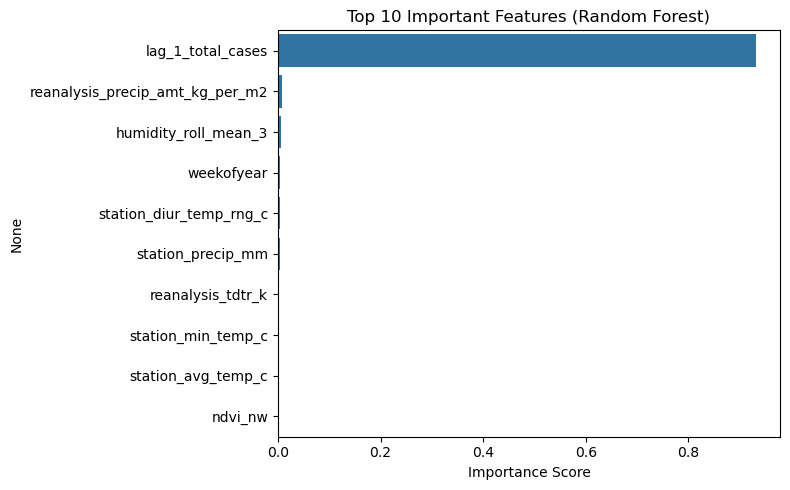

In [20]:
from sklearn.ensemble import RandomForestRegressor
# Train a quick model on all numeric features
X = data.drop(columns=["total_cases"])
y = data["total_cases"]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importance
importance = pd.Series(model.feature_importances_, index=X.columns)
importance = importance.sort_values(ascending=False)

# Show top 10
plt.figure(figsize=(8, 5))
sns.barplot(x=importance[:10].values, y=importance[:10].index)
plt.title("Top 10 Important Features (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# Keep only top 10 for modeling
selected_features_rf = importance[:10].index.tolist()


In [21]:
from sklearn.model_selection import train_test_split

X = train[selected_features_rf]  # or your final feature list
y = train["total_cases"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = model.predict(X_valid)

mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 8.277972508591066
RMSE: 17.487407948857356


✅ Gradient Boosting Regressor Performance
MAE: 8.88
RMSE: 19.16


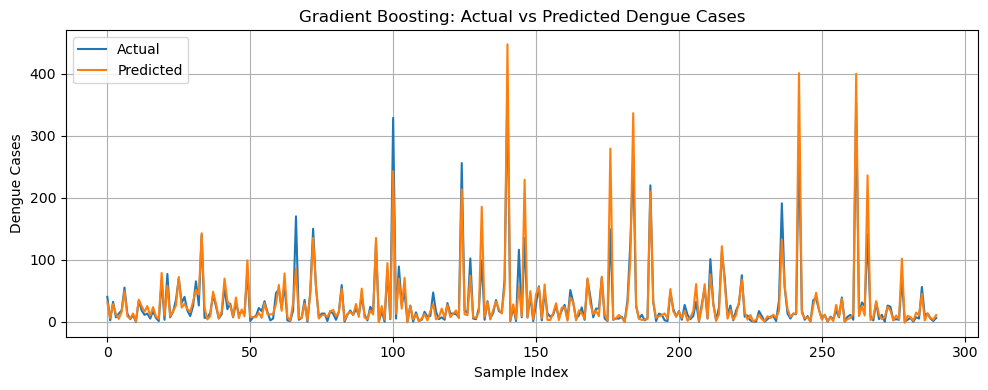

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# ✅ Step 1: Define selected features manually
selected_features_rf = [
    'lag_1_total_cases',
    'reanalysis_precip_amt_kg_per_m2',
    'humidity_roll_mean_3',
    'weekofyear',
    'station_diur_temp_rng_c',
    'reanalysis_tdtr_k',
    'station_avg_temp_c',
    'reanalysis_relative_humidity_percent',
    'reanalysis_dew_point_temp_k',
    'reanalysis_avg_temp_k'
]

# ✅ Step 2: Split data
X = train[selected_features_rf]
y = train["total_cases"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Step 3: Train Gradient Boosting Regressor
gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gbr.fit(X_train, y_train)

# ✅ Step 4: Evaluate
y_pred = gbr.predict(X_valid)

mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

print("✅ Gradient Boosting Regressor Performance")
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))

# ✅ Step 5: Plot Actual vs Predicted
plt.figure(figsize=(10, 4))
plt.plot(y_valid.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("Gradient Boosting: Actual vs Predicted Dengue Cases")
plt.xlabel("Sample Index")
plt.ylabel("Dengue Cases")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



In [25]:

# Create two separate datasets
train_sj = train[train["city"] == 0]  # San Juan
train_iq = train[train["city"] == 1]  # Iquitos


In [26]:
features = [
    'lag_1_total_cases',
    'reanalysis_precip_amt_kg_per_m2',
    'humidity_roll_mean_3',
    'weekofyear',
    'station_diur_temp_rng_c',
    'reanalysis_tdtr_k',
    'station_avg_temp_c',
    'reanalysis_relative_humidity_percent',
    'reanalysis_dew_point_temp_k',
    'reanalysis_avg_temp_k'
]

X_sj = train_sj[features]
y_sj = train_sj["total_cases"]

X_iq = train_iq[features]
y_iq = train_iq["total_cases"]


In [27]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# Split each city data
X_sj_train, X_sj_val, y_sj_train, y_sj_val = train_test_split(X_sj, y_sj, test_size=0.2, random_state=42)
X_iq_train, X_iq_val, y_iq_train, y_iq_val = train_test_split(X_iq, y_iq, test_size=0.2, random_state=42)

# Train model for San Juan
model_sj = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
model_sj.fit(X_sj_train, y_sj_train)

# Train model for Iquitos
model_iq = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
model_iq.fit(X_iq_train, y_iq_train)


GradientBoostingRegressor(n_estimators=200, random_state=42)

In [28]:
from sklearn.metrics import mean_absolute_error

pred_sj = model_sj.predict(X_sj_val)
pred_iq = model_iq.predict(X_iq_val)

mae_sj = mean_absolute_error(y_sj_val, pred_sj)
mae_iq = mean_absolute_error(y_iq_val, pred_iq)

print("San Juan MAE:", round(mae_sj, 2))
print("Iquitos MAE:", round(mae_iq, 2))


San Juan MAE: 7.99
Iquitos MAE: 4.44


In [29]:
# ---------------------
# 🔄 Step 1: Load and process test data
# ---------------------
test_features = pd.read_csv("dengue_features_test.csv")
test_features["city"] = test_features["city"].map({"sj": 0, "iq": 1})
test_features = test_features.ffill()
test_features = test_features.drop(columns=["week_start_date"])

# Feature engineering (repeat same steps as training!)
test_features["lag_1_total_cases"] = 0  # No previous week cases in test, fill with 0
test_features["humidity_roll_mean_3"] = test_features["reanalysis_relative_humidity_percent"].rolling(3).mean()
test_features = test_features.fillna(0)

# ---------------------
# 📦 Step 2: Define final selected features
# ---------------------
final_features = [
    'lag_1_total_cases',
    'reanalysis_precip_amt_kg_per_m2',
    'humidity_roll_mean_3',
    'weekofyear',
    'station_diur_temp_rng_c',
    'reanalysis_tdtr_k',
    'station_avg_temp_c',
    'reanalysis_relative_humidity_percent',
    'reanalysis_dew_point_temp_k',
    'reanalysis_avg_temp_k'
]

# ---------------------
# 🏙 Step 3: Split by city and predict
# ---------------------
test_sj = test_features[test_features["city"] == 0].copy()
test_iq = test_features[test_features["city"] == 1].copy()

pred_sj = model_sj.predict(test_sj[final_features])
pred_iq = model_iq.predict(test_iq[final_features])

# Round and convert to int
test_sj["total_cases"] = np.round(pred_sj).astype(int)
test_iq["total_cases"] = np.round(pred_iq).astype(int)

# ---------------------
# 🔗 Step 4: Merge and sort predictions
# ---------------------
final_pred = pd.concat([test_sj, test_iq])
final_pred = final_pred[["city", "year", "weekofyear", "total_cases"]]
final_pred = final_pred.sort_values(by=["city", "year", "weekofyear"])

# ---------------------
# 💾 Step 5: Export to CSV
# ---------------------
final_pred.to_csv("dengue_predictions.csv", index=False)
print("✅ Final predictions saved to 'dengue_predictions.csv'")


✅ Final predictions saved to 'dengue_predictions.csv'
